## Data download(name data)

In [ ]:
!wget https://download.pytorch.org/tutorial/data.zip

--2023-05-20 07:30:48--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.86.38.37, 99.86.38.106, 99.86.38.96, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.86.38.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip.1’

data.zip.1          100%[===================>]   2.75M  --.-KB/s    in 0.05s   

2023-05-20 07:30:48 (50.7 MB/s) - ‘data.zip.1’ saved [2882130/2882130]



In [ ]:
!unzip data.zip

Archive:  data.zip
replace data/eng-fra.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: data/eng-fra.txt        
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Italian.txt  
  inflating: data/names/Japanese.txt  
  inflating: data/names/Korean.txt   
  inflating: data/names/Polish.txt   
  inflating: data/names/Portuguese.txt  
  inflating: data/names/Russian.txt  
  inflating: data/names/Scottish.txt  
  inflating: data/names/Spanish.txt  
  inflating: data/names/Vietnamese.txt  


### utils

In [ ]:
# data: https://download.pytorch.org/tutorial/data.zip
import io
import os
import unicodedata
import string
import glob

import torch
import random

# alphabet small + capital letters + " .,;'"
ALL_LETTERS = string.ascii_letters + " .,;'"
N_LETTERS = len(ALL_LETTERS)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in ALL_LETTERS
    )

def load_data():
    # Build the category_lines dictionary, a list of names per language
    category_lines = {}
    all_categories = []
    
    def find_files(path):
        return glob.glob(path)
    
    # Read a file and split into lines
    def read_lines(filename):
        lines = io.open(filename, encoding='utf-8').read().strip().split('\n')
        return [unicode_to_ascii(line) for line in lines]
    
    for filename in find_files('data/names/*.txt'):
        category = os.path.splitext(os.path.basename(filename))[0]
        all_categories.append(category)
        
        lines = read_lines(filename)
        category_lines[category] = lines
        
    return category_lines, all_categories



"""
To represent a single letter, we use a “one-hot vector” of 
size <1 x n_letters>. A one-hot vector is filled with 0s
except for a 1 at index of the current letter, e.g. "b" = <0 1 0 0 0 ...>.
To make a word we join a bunch of those into a
2D matrix <line_length x 1 x n_letters>.
That extra 1 dimension is because PyTorch assumes
everything is in batches - we’re just using a batch size of 1 here.
"""

# Find letter index from all_letters, e.g. "a" = 0
def letter_to_index(letter):
    return ALL_LETTERS.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letter_to_tensor(letter):
    tensor = torch.zeros(1, N_LETTERS)
    tensor[0][letter_to_index(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, N_LETTERS)
    for i, letter in enumerate(line):
        tensor[i][0][letter_to_index(letter)] = 1
    return tensor


def random_training_example(category_lines, all_categories):
    
    def random_choice(a):
        random_idx = random.randint(0, len(a) - 1)
        return a[random_idx]
    
    category = random_choice(all_categories)
    line = random_choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor



if __name__ == '__main__':
    print(ALL_LETTERS)
    print(unicode_to_ascii('Ślusàrski'))
    
    category_lines, all_categories = load_data()
    print(category_lines['Italian'][:5])
    
    print(letter_to_tensor('J')) # [1, 57]
    print(line_to_tensor('Jones').size()) # [5, 1, 57]

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'
Slusarski
['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


### train

Arabic
5000 5.0 2.7090 Voclain / Irish WRONG (French)
10000 10.0 3.7694 Smit / Chinese WRONG (Dutch)
15000 15.0 2.0484 Stangl / Czech CORRECT
20000 20.0 0.0768 Hayakawa / Japanese CORRECT
25000 25.0 2.5631 Dasios / Arabic WRONG (Greek)
30000 30.0 2.9531 Graham / Arabic WRONG (Scottish)
35000 35.0 1.1306 Basurto / Portuguese CORRECT
40000 40.0 0.2593 Niemczyk / Polish CORRECT
45000 45.0 1.8594 Mayer / Arabic WRONG (German)
50000 50.0 4.0420 Stewart / Dutch WRONG (Scottish)
55000 55.00000000000001 2.1658 Rapp / English WRONG (German)
60000 60.0 1.3759 Saller / German CORRECT
65000 65.0 1.5662 Caron / Greek WRONG (French)
70000 70.0 0.0301 Janowski / Polish CORRECT
75000 75.0 1.2190 Hanek / Czech CORRECT
80000 80.0 3.5499 Williamson / Scottish WRONG (English)
85000 85.0 0.1341 Gabrielli / Italian CORRECT
90000 90.0 0.0310 Agrikov / Russian CORRECT
95000 95.0 1.3695 Best / German CORRECT
100000 100.0 0.4072 Millar / Scottish CORRECT


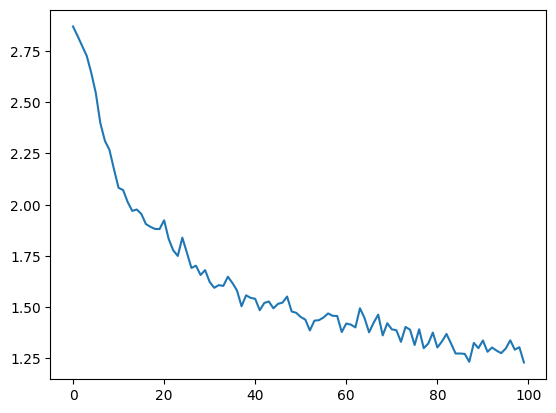

In [ ]:
import torch
import torch.nn as nn 
import matplotlib.pyplot as plt 


class RNN(nn.Module):
    # implement RNN from scratch rather than using nn.RNN
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input_tensor, hidden_tensor):
        combined = torch.cat((input_tensor, hidden_tensor), 1)
        
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)
    
category_lines, all_categories = load_data()
n_categories = len(all_categories)

n_hidden = 128
rnn = RNN(N_LETTERS, n_hidden, n_categories)

# one step
input_tensor = letter_to_tensor('A')
hidden_tensor = rnn.init_hidden()

output, next_hidden = rnn(input_tensor, hidden_tensor)
#print(output.size())
#print(next_hidden.size())

# whole sequence/name
input_tensor = line_to_tensor('Albert')
hidden_tensor = rnn.init_hidden()

output, next_hidden = rnn(input_tensor[0], hidden_tensor)
#print(output.size())
#print(next_hidden.size())

#
def category_from_output(output):
    category_idx = torch.argmax(output).item()
    return all_categories[category_idx]

print(category_from_output(output))

criterion = nn.NLLLoss()
learning_rate = 0.005
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

def train(line_tensor, category_tensor):
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    loss = criterion(output, category_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output, loss.item()

current_loss = 0
all_losses = []
plot_steps, print_steps = 1000, 5000
n_iters = 100000
for i in range(n_iters):
    category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)
    
    output, loss = train(line_tensor, category_tensor)
    current_loss += loss 
    
    if (i+1) % plot_steps == 0:
        all_losses.append(current_loss / plot_steps)
        current_loss = 0
        
    if (i+1) % print_steps == 0:
        guess = category_from_output(output)
        correct = "CORRECT" if guess == category else f"WRONG ({category})"
        print(f"{i+1} {(i+1)/n_iters*100} {loss:.4f} {line} / {guess} {correct}")
        
    
plt.figure()
plt.plot(all_losses)
plt.show()



### Predict

In [ ]:
def predict(input_line):
    print(f"\n> {input_line}")
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)
        
        hidden = rnn.init_hidden()
    
        for i in range(line_tensor.size()[0]):
            output, hidden = rnn(line_tensor[i], hidden)
        
        guess = category_from_output(output)
        print(guess)


while True:
    sentence = input("Input:")
    if sentence == "quit":
        break
    
    predict(sentence)
    

Input:Lan, Liem

> Lan, Liem
Dutch
Input:Khanh

> Khanh
Vietnamese
Input:Visser

> Visser
German
Input:quit
